## Exploration, Analysis and Classification of the Sentiment140 Dataset

In this notebook you'll find the exploration, analysis and the modelling for the Sentiment140 dataset, a collection of 1.6 million dataset positive and negative tweets, noisily labelled by the emoticons in their text as positive or negative.

In [1]:
import sys
import emo_unicode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('wwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import WordNetLemmatizer # Stemmer & Lemmatizer
from emo_unicode import *

# Text Embedding and Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.sparse as sparse
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import html
# Saving Model
import pickle


In [2]:
#Importing the dataset
tweets = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', names = ['Target', 'ID','Date','Query','Username', 'tweet'], encoding='latin-1')

In [3]:
tweets.Query.unique()

array(['NO_QUERY'], dtype=object)

Since the value for "Query" is redundant, we drop it.. and it doesn't make sense to assume a username would incline a person to be more negative or positive so we drop that column as well

In [4]:
tweets = tweets.drop(['Query','Username'], axis = 1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(790000.0, 810000.0)

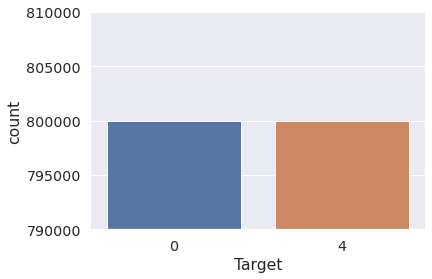

In [5]:
sns.countplot(tweets['Target'])
plt.ylim([790000,810000])

Our positive (with target variable 4) / negative reviews (with target variable 0) are balanced ith 800,000 samples for each class, Great! There will be no imbalance to impact our predictive algorithms!

Let's convert the date string to pandas' DateTime and save it to observe and visualize the data

In [6]:
tweets.Date = tweets.Date.str.replace('PDT', '')
tweets.Date = pd.to_datetime(tweets.Date)

## Data Exploration

#### Let's try to find relationships between our variables and interesting facts about our data..

At what time of day do people tweet the most? Are tweets at a certain time more negative than others?

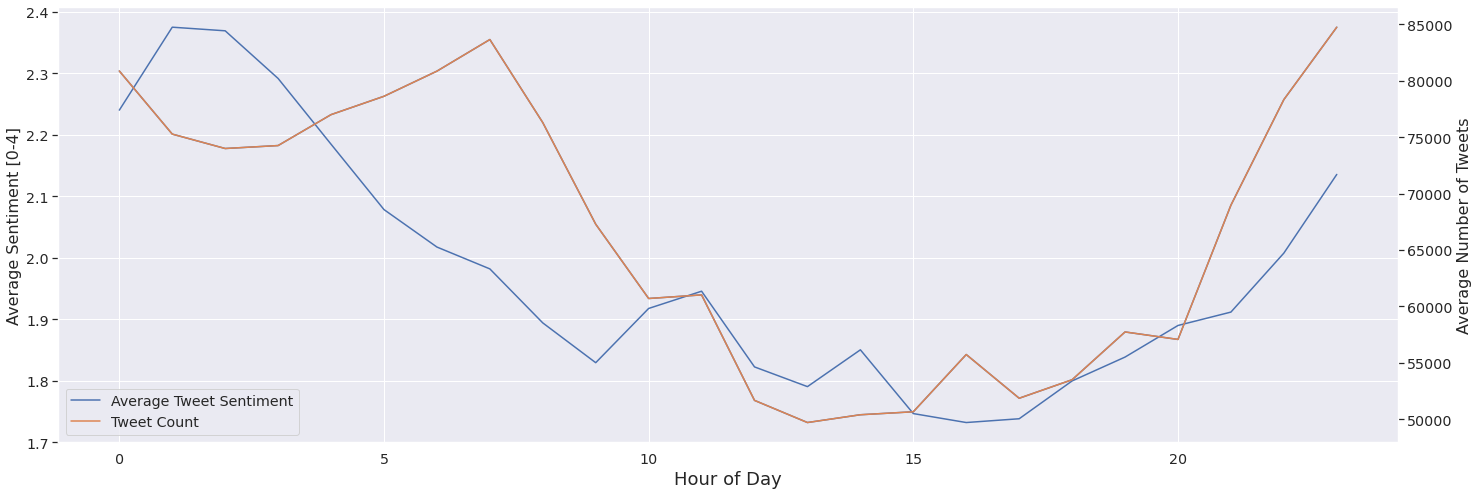

In [7]:
tweetie = tweets[['Date','Target']]
fig, ax = plt.subplots(1,1,figsize=(24,8))
obj = tweetie.groupby([tweets.Date.dt.hour])
ax.plot(obj.mean())
e = ax.twinx()
e.plot(obj.count())
e.grid(None)
plt.legend(['Average Tweet Sentiment', 'Tweet Count'], loc = 'lower left', fancybox = True)
ax.set_xlabel('Hour of Day', fontsize=18)
ax.set_ylabel('Average Sentiment [0-4]', fontsize=16)
e.set_ylabel('Average Number of Tweets', fontsize=16);

It seems like that people tweet more on average after the usual business hours at the end of the day and late into the night, although it seems like the most positive tweets occure at night and when people aren't working! People seem grumpier at work..

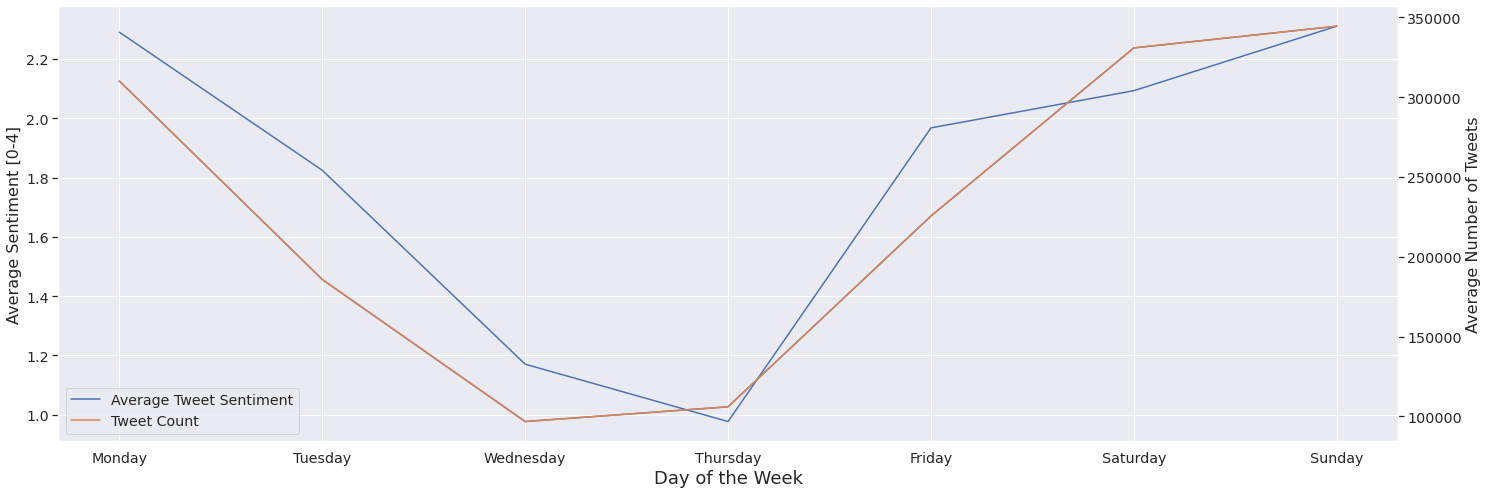

In [8]:
tweetie = tweets[['Date','Target']]
fig, ax = plt.subplots(1,1,figsize=(24,8))
obj = tweetie.groupby([tweets.Date.dt.weekday])
ax.plot(obj.mean())
e = ax.twinx()
e.plot(obj.count())
e.grid(None)
plt.legend(['Average Tweet Sentiment', 'Tweet Count'], loc = 'lower left', fancybox = True)
fig.suptitle('', fontsize=20)
ax.set_xlabel('Day of the Week', fontsize=18)
ax.xaxis.set(ticks=range(0,7) ,ticklabels=['Monday' , 'Tuesday', "Wednesday", 'Thursday', "Friday", "Saturday", "Sunday"])
ax.set_ylabel('Average Sentiment [0-4]', fontsize=16)
e.set_ylabel('Average Number of Tweets', fontsize=16);

The average amount of tweets trends downwards as people progress into the weekday, and they start tweeting more again as the weekend starts it seems, they're even more positive! Is this because a certain group of positive tweeters come into the mix which are freer on the weekends? Or is it the same set of people but grumpier? A much more thorough analysis is needed to answer that, we will leave it at that for now and focus on the sentiment prediction portion of this notebook

## Text pre-processing and feature extraction

Lets' prepare some lemmatizing and stop-word removal functions that work on a per sentence basis to use on our tweets to "normalize" our text data..

An average tweet consists of the following special instances of text, besides language:

- Links
- Hashtags
- User Mentions (@)
- HTML Special Entities eg: "\&gt;" which translates to a greater than sign (>)
- Emoticons eg: "=)"

The approach taken to pre process the text was the following:

##### <b>Links</b>:
To not lose any data, links were replaced with the word "URL", this could possibly be impactful if useres for example posted a link, which can also be a picture due to how twitter works, or if a user posted multiple links it could indicate a more positive or a more negative tweet.

##### <b>Hashtags</b>:
Hashtags are left as they are with the "#" symbol removed as a hashtag can either represent a word that shows a feeling like "#lol" or "#excited" or can represent an either positive or negative trend.

##### <b>User mentions</b>:
For a similar reason as the ones above, all user mentions were changed to all be the word "USER", since it could be possible that a person doesn't mention as much, or even mentions more when there's a specific polarity to the tweet.

##### <b>HTML Special Entities</b>:
These represent only symbols, which isn't very useful to our word based sentimental analysis algorithm. However, they can be part of an emoticon, which is the only reason they're mapped to the characters they represent in our processing functions can signify either positive or negative sentiment.

#### <b>Emoticons</b>:

Again, to not lose any information, we map these emoticons to their meaning / how they could possibly be interpreted by the average person, for example:
- ":‑)"  <b>_maps to_</b>  "Happy face or smiley"

- "}:)" <b>_maps to_</b> "Evil or devilish"

- ""\&gt;:/" (after HTML Entity processing: " >:/ ") <b>_maps to_</b> "Skeptical, annoyed, undecided, uneasy or hesitant" 


In [9]:
stop= set(stopwords.words('english'))

processing_dict  = {
        r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)" : 'URL' , #Links
        r"&\w{2,5};": ' ', #User mentions
        r"@[^\s]+":  'USER', #HTML Special Entities
}
def process_text(txt):
        txt = txt.lower()
        txt = html.unescape(txt)
        for toreplace,replacement  in processing_dict.items():
            txt = re.sub(toreplace,replacement,txt)  
        for emoji,feeling  in EMOTICONS_EMO.items():
            txt = txt.replace(emoji,feeling)
        return txt

tweets['processed_tweet'] = tweets.tweet.apply(process_text)

A quick piece of visualization below, about tweet length and sentiment

Are people angrier the more they talk in a tweet turning it into a rant? 

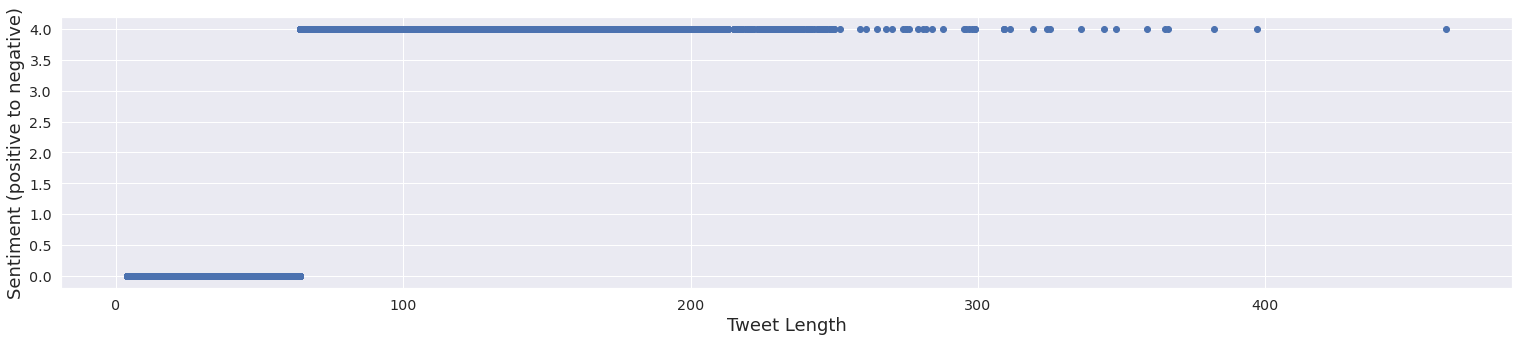

In [10]:
tweets["Length"] = tweets.processed_tweet.str.len()
plt.figure(figsize=(26,5))
plt.scatter(tweets.sort_values('Length')['Length'],tweets.Target)
plt.gca().set_xlabel('Tweet Length', fontsize=18)
plt.gca().set_ylabel('Sentiment (positive to negative)', fontsize=18);

With this visualization now enabled because any links, longer user mentions and HTML entities processed I would've expect the longer tweets to be more rant-like but surprisingly it's the other way around! Shorter tweets are always more negative than longer ones 

Even more interesting is that this graph is shaped much like a logistic function, behind the scenes of making this notebook though, it actually worsened the logistic algorithm result!

#### More preprocessing!


Next up we remove all stop words, like 'and', 'or', or 'the' as they don't show any sentiment and are repeated in almost all text. They're useless to our model

Then we lemmetize all words to their root word, this was chosen instead of stemming in hopes that the extra context it can provide will provide better results than the faster stemming algorithm.

Lastly, we remove all symbols and special charcters, as they don't help the model.

In [11]:
lemmatizer = WordNetLemmatizer()
def remove_stopwords(text):
    stopwordsfree=" ".join([ x for x in text.split() if x not in stop])
    return stopwordsfree

def lemmetize_sentence(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

def clean_text(txt):
        txt = re.sub(r"(.)\1\1+",r"\1\1",txt)
         #Typo, or exaggeration fixer, replace any charcters repeated more than twice with just two
         #characters eg: Cottton -> Cotton  or  Amazingggg to Amazingg }
        txt = re.sub(r'[^a-zA-Z0-9]',' ',txt)
        return txt
tweets['lemmetized_processed_tweet'] = tweets.processed_tweet.apply(lambda x:clean_text(remove_stopwords(lemmetize_sentence(x))))

The few visualization prior showed that both weekdays AND time of the day had a significant impact on tweet sentiment, it was not at all random especially  since it's based on the average of such a large population of tweets...

We decided to extract these features and inculde them in our model, hoping for better performance.

In [12]:
#Make the feature dicts
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
hour_map={n: 'Hour {0}'.format(n) for n in range(24)}

#Extract the features from the data
tweets['dotw'] = tweets.Date.dt.weekday
tweets['hourofday'] = tweets.Date.dt.hour

#Translate them into words instead of integers for better readibility
tweets.dotw =tweets.dotw.apply(lambda x: weekday_map[x])
tweets.hourofday =tweets.hourofday.apply(lambda x: hour_map[x])

enc =OneHotEncoder(handle_unknown='ignore')

#one hot encode the large number of values to feed into our model easier and not require as much memory
day =enc.fit_transform(tweets['dotw'].values.reshape(-1, 1))
time =enc.fit_transform(tweets['hourofday'].values.reshape(-1, 1))

##tape them together =)
time_day = sparse.hstack((day,time))
#Vectorizing and extracting the day of the week feature

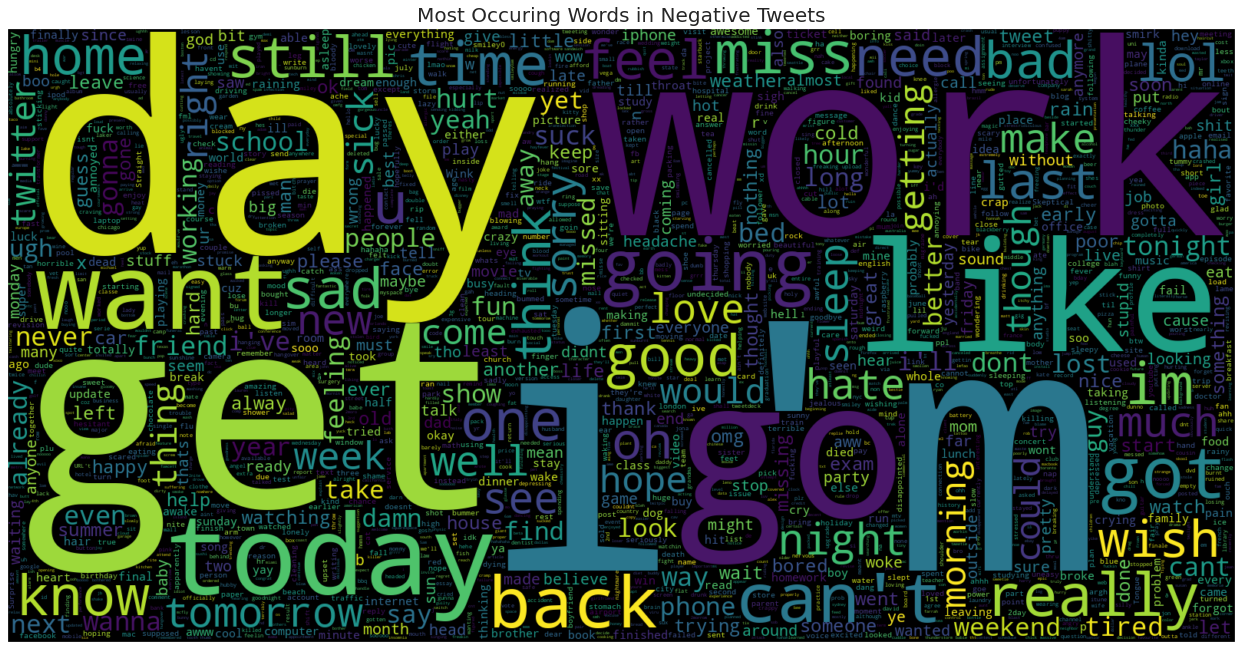

In [13]:
#Normalizing target to be from 0 to 1 as it's easier to deal with for the algorithms
tweets.Target = tweets.Target.apply(lambda x : 0 if x ==0 else 1)
from wordcloud import WordCloud
plt.figure(figsize = (22,22)) 
ax = plt.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
stop.update({'url','user'})
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,collocations=False,stopwords= stop).generate(" ".join(tweets[tweets.Target == 0].processed_tweet))
plt.imshow(wc , interpolation = 'bilinear');
ax.set_title('Most Occuring Words in Negative Tweets', fontsize=20);

Above and below we try to visualize our text data with the most occuring words in both positive and negative tweets

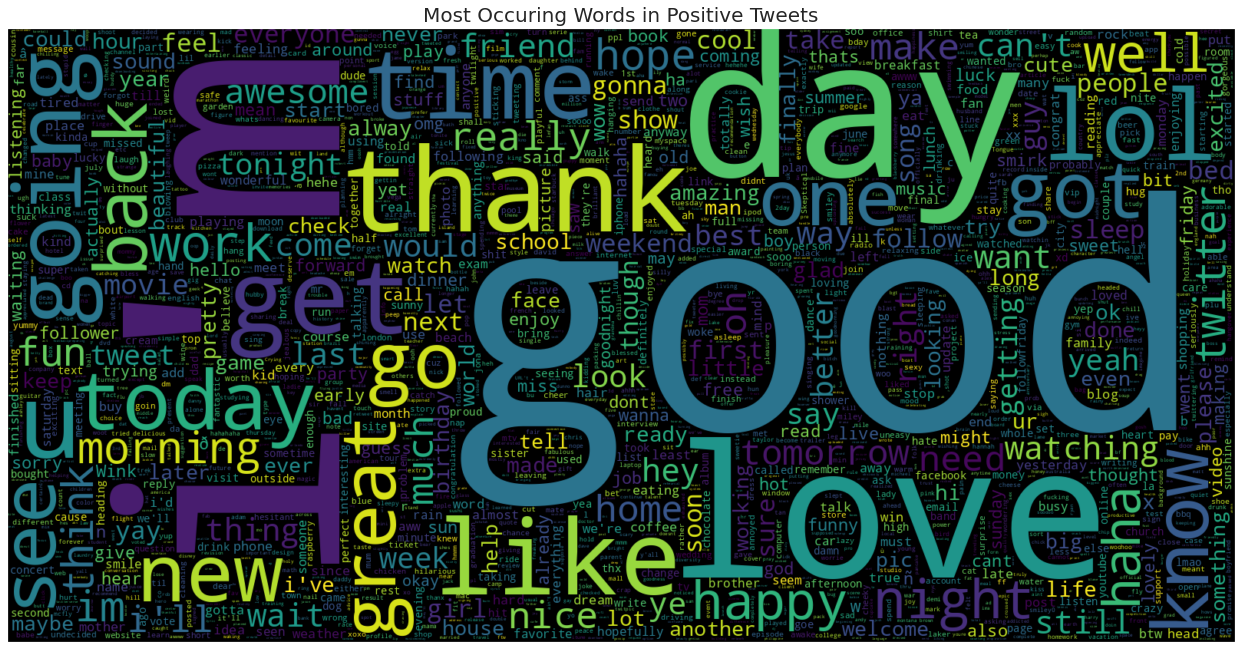

In [14]:
from wordcloud import WordCloud
plt.figure(figsize = (22,22)) 
ax = plt.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,collocations=False,stopwords= stop).generate(" ".join(tweets[tweets.Target == 1].processed_tweet))
plt.imshow(wc , interpolation = 'bilinear');
ax.set_title('Most Occuring Words in Positive Tweets', fontsize=20);

Then we prepare the data for model selection, to X and Y, our independant and dependant variables respectively and, by dividing it into two sets, training and test, and attaching the features like weekday and hour to it:

In [15]:
tweets = pd.concat([tweets, pd.DataFrame(time_day.toarray(), columns = (list(weekday_map.values()) + list(hour_map.values())) )], axis = 1)
X = tweets[['lemmetized_processed_tweet'] + list(weekday_map.values()) + list(hour_map.values())]
y = tweets['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Above, we split our data for training and testing and below we vectorize the lemmetized tweets for model training

We then vectorize our text data only with a TF-IDF vectorizer which reduced the importance of the more often repeated words

In [16]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train['lemmetized_processed_tweet'].values,y_train.values)
# transform on training text data
X_train_text = vectorizer.transform(X_train['lemmetized_processed_tweet'].values)
# transform on testing text data
X_test_text = vectorizer.transform(X_test['lemmetized_processed_tweet'].values)

After transforming the TFIDF model on the text only we concatenate it back to the samples in a sparse matrix to save space

And we do the same for the test data

In [17]:
finalxtrain = sparse.hstack((sparse.csr_matrix(X_train[list(weekday_map.values()) + list(hour_map.values())].values), X_train_text))
finalxtest= sparse.hstack((sparse.csr_matrix(X_test[list(weekday_map.values()) + list(hour_map.values())].values), X_test_text))

Finally, the data is attached in a sparse matrix to be fed to the model

## Model Training and Selection

We chose fairly popular models for sentiment analysis which are Logistic Regression as well as SVC and MultiNomial Naive Bayes and we store their results in a handy dictionary

In [18]:
prediction = dict()

In [19]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(finalxtrain, y_train)
prediction['Multinomial'] = model.predict(finalxtest)

In [20]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(finalxtrain, y_train)
prediction['SVC'] = SVCmodel.predict(finalxtest)

In [21]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='liblinear', C = 2, max_iter = 1000)
logreg.fit(finalxtrain, y_train)
prediction['Logistic'] = logreg.predict(finalxtest)

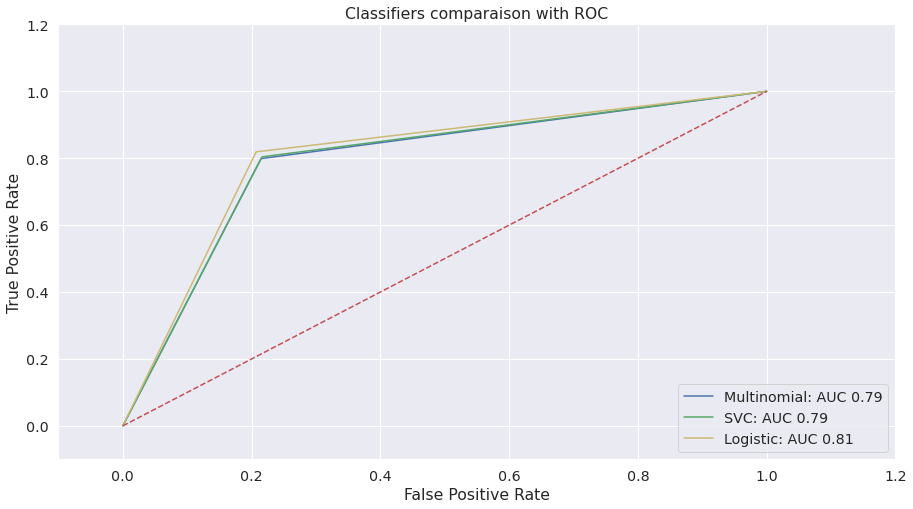

In [22]:
#Plotting an AUC-ROC curve to compare algorithms
cmp = 0
colors = ['b', 'g', 'y','cyan']
plt.figure(figsize=(15,8))
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.81      0.79      0.80    159494
    negative       0.80      0.82      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



The AUC-ROC curve above indicates that Logistic Regression gave us the best possible performance of the three.

## We achieved an AUC of .81 and an f1 score of .805, not bad!

### Saving the model for production

In [24]:
model_name = 'logistic_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = './'+ model_name
vect_path = './'+vectorizer_name

In [25]:
pickle.dump(vectorizer_tfidf , open(vect_path,'wb'))
pickle.dump(logreg , open(model_path,'wb'))

### Loading and testing the model again

In [26]:
loaded_model = pickle.load(open(model_path,'rb'))
loaded_vect = pickle.load(open(vect_path,'rb'))
def analyze_tweet(txt):
    txt = clean_text(remove_stopwords(lemmetize_sentence(process_text(txt))))
    week = np.zeros(31)
    week[pd.Timestamp.now().weekday()] = 1
    week[pd.Timestamp.now().hour] = 1
    mx = loaded_vect.transform([txt]) 
    pos,neg  = loaded_model.predict_proba(sparse.hstack((mx,sparse.csr_matrix(week))))[0]
    print(pos,neg)
    if pos <=0.58 and pos >=0.42:
        return 1
    elif pos>0.52:
        return 2
    else:
        return 0

In [27]:
twt = tweets.iloc[5656,:]
cleaned, target =process_text(twt.tweet), twt.Target
print(twt.tweet , twt.Target)
print(analyze_tweet(cleaned), '<-- Model prediction (0,1)')

Daylight saving is over  it I'd now dark at 7! Not fair! I don't like it  0
0.3038124677167855 0.6961875322832145
0 <-- Model prediction (0,1)


Hope it was an enjoyable read!

By Omar Ibrahim
https://www.linkedin.com/in/omar-png/